# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [5]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [6]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [23]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
    Как мы знаем, градиент данной функции будет следующим: (2cosx, 2cosy). 
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """

    return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [25]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [26]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [27]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

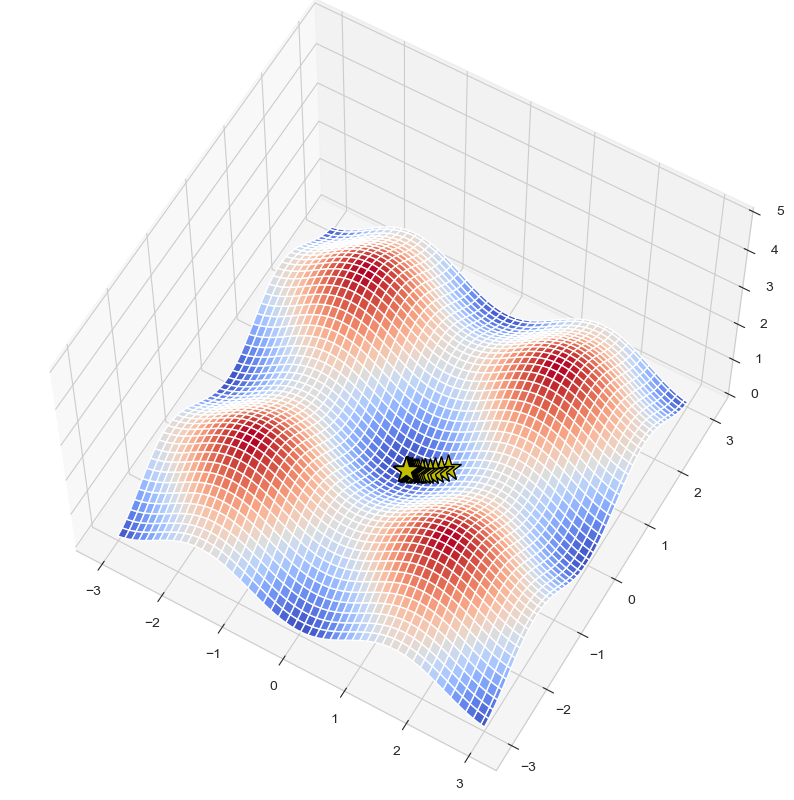

In [28]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

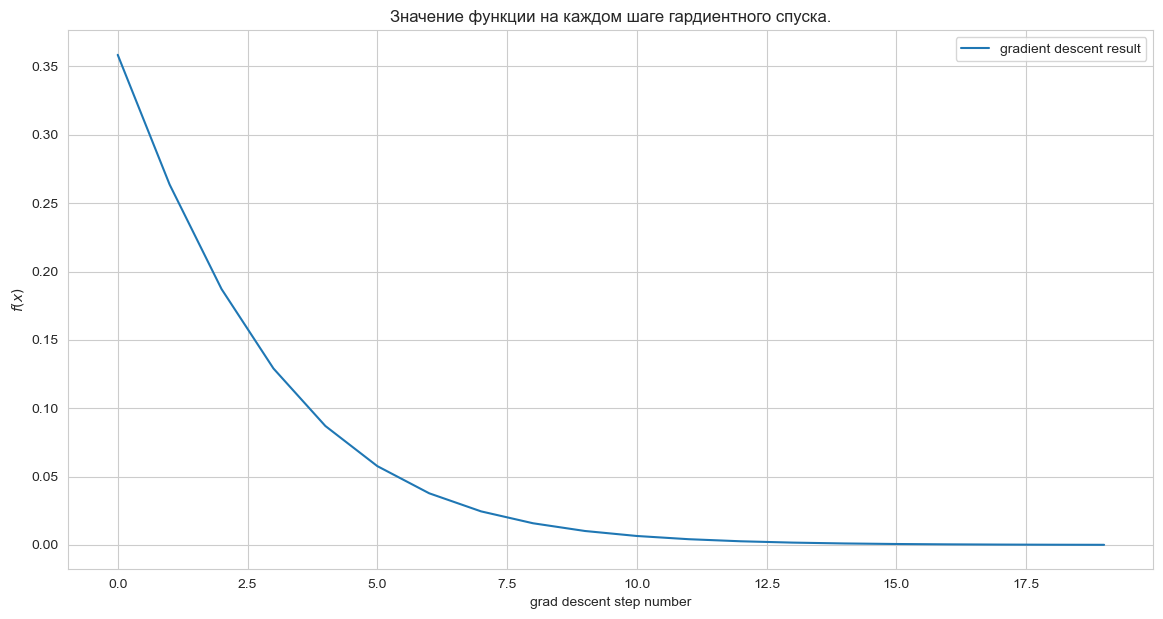

In [29]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

In [34]:
d = np.array([[1,2,3], [4, 5, 6]])
d.T @ np.array([2, 2])

array([10, 14, 18])

#### Задание 2.1. MSE и ее градиент (2 балла)

In [35]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2*(X.T @ (y_pred - y_true)) / np.size(y_true)


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [36]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [37]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободный член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X - intercept?
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [43]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        
        # добавляем колонку из единиц для свободного члена
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        y_pred = X_test @ self.W
        
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [44]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

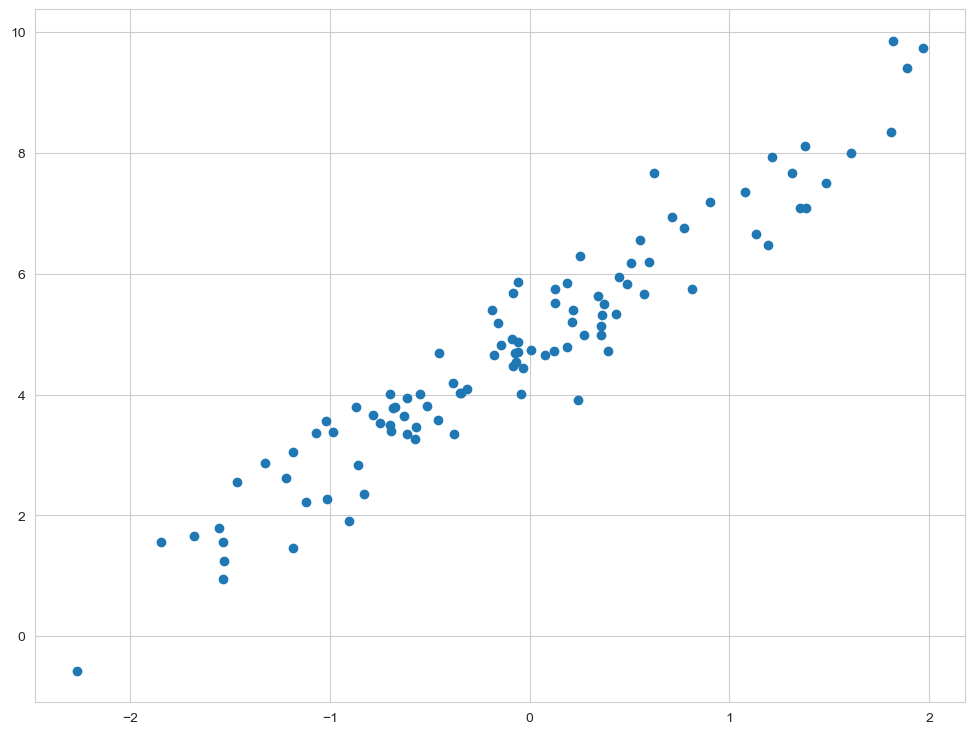

In [45]:
plt.scatter(X, y);

In [46]:
custom_lin_reg = CustomLinearRegression()

In [47]:
custom_lin_reg.fit(X, y)

My custom linear regression

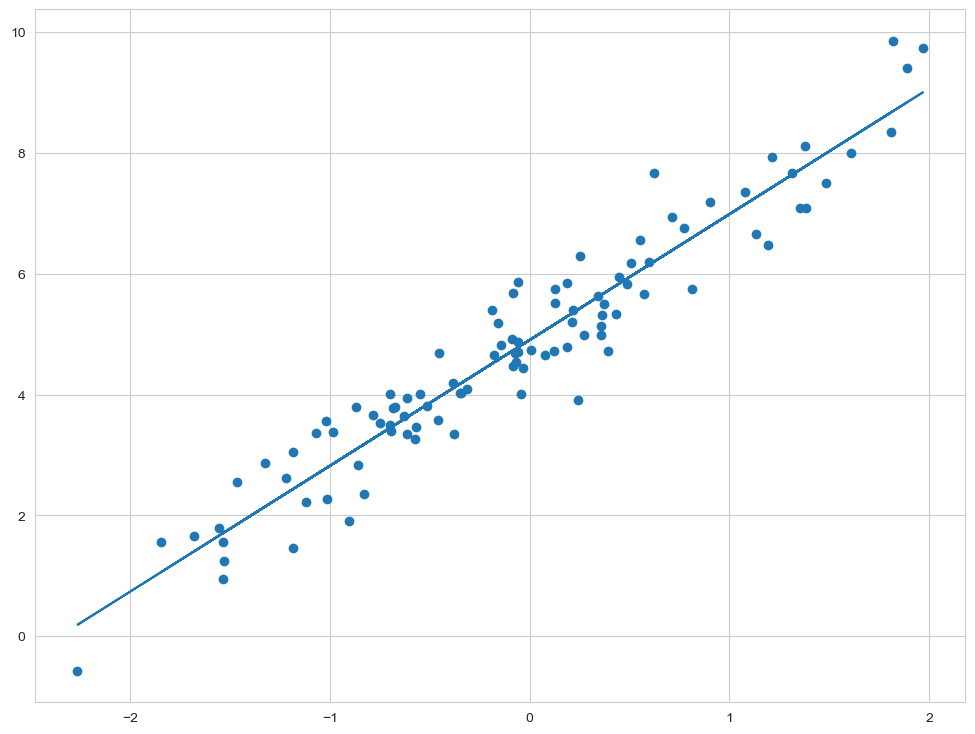

In [48]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [49]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [62]:
df = pd.DataFrame(X, columns=feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [63]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Как мы можем видеть, среднее и стандартное отклонение для разных параметров у нас сильно различаются. Чтобы нормализовать значения, применим StandartScaler. Кроме того, можно отметить, что все признаки у нас численные, нет категориальных.

Посмотрим на распределения признаков и возможные корреляции:

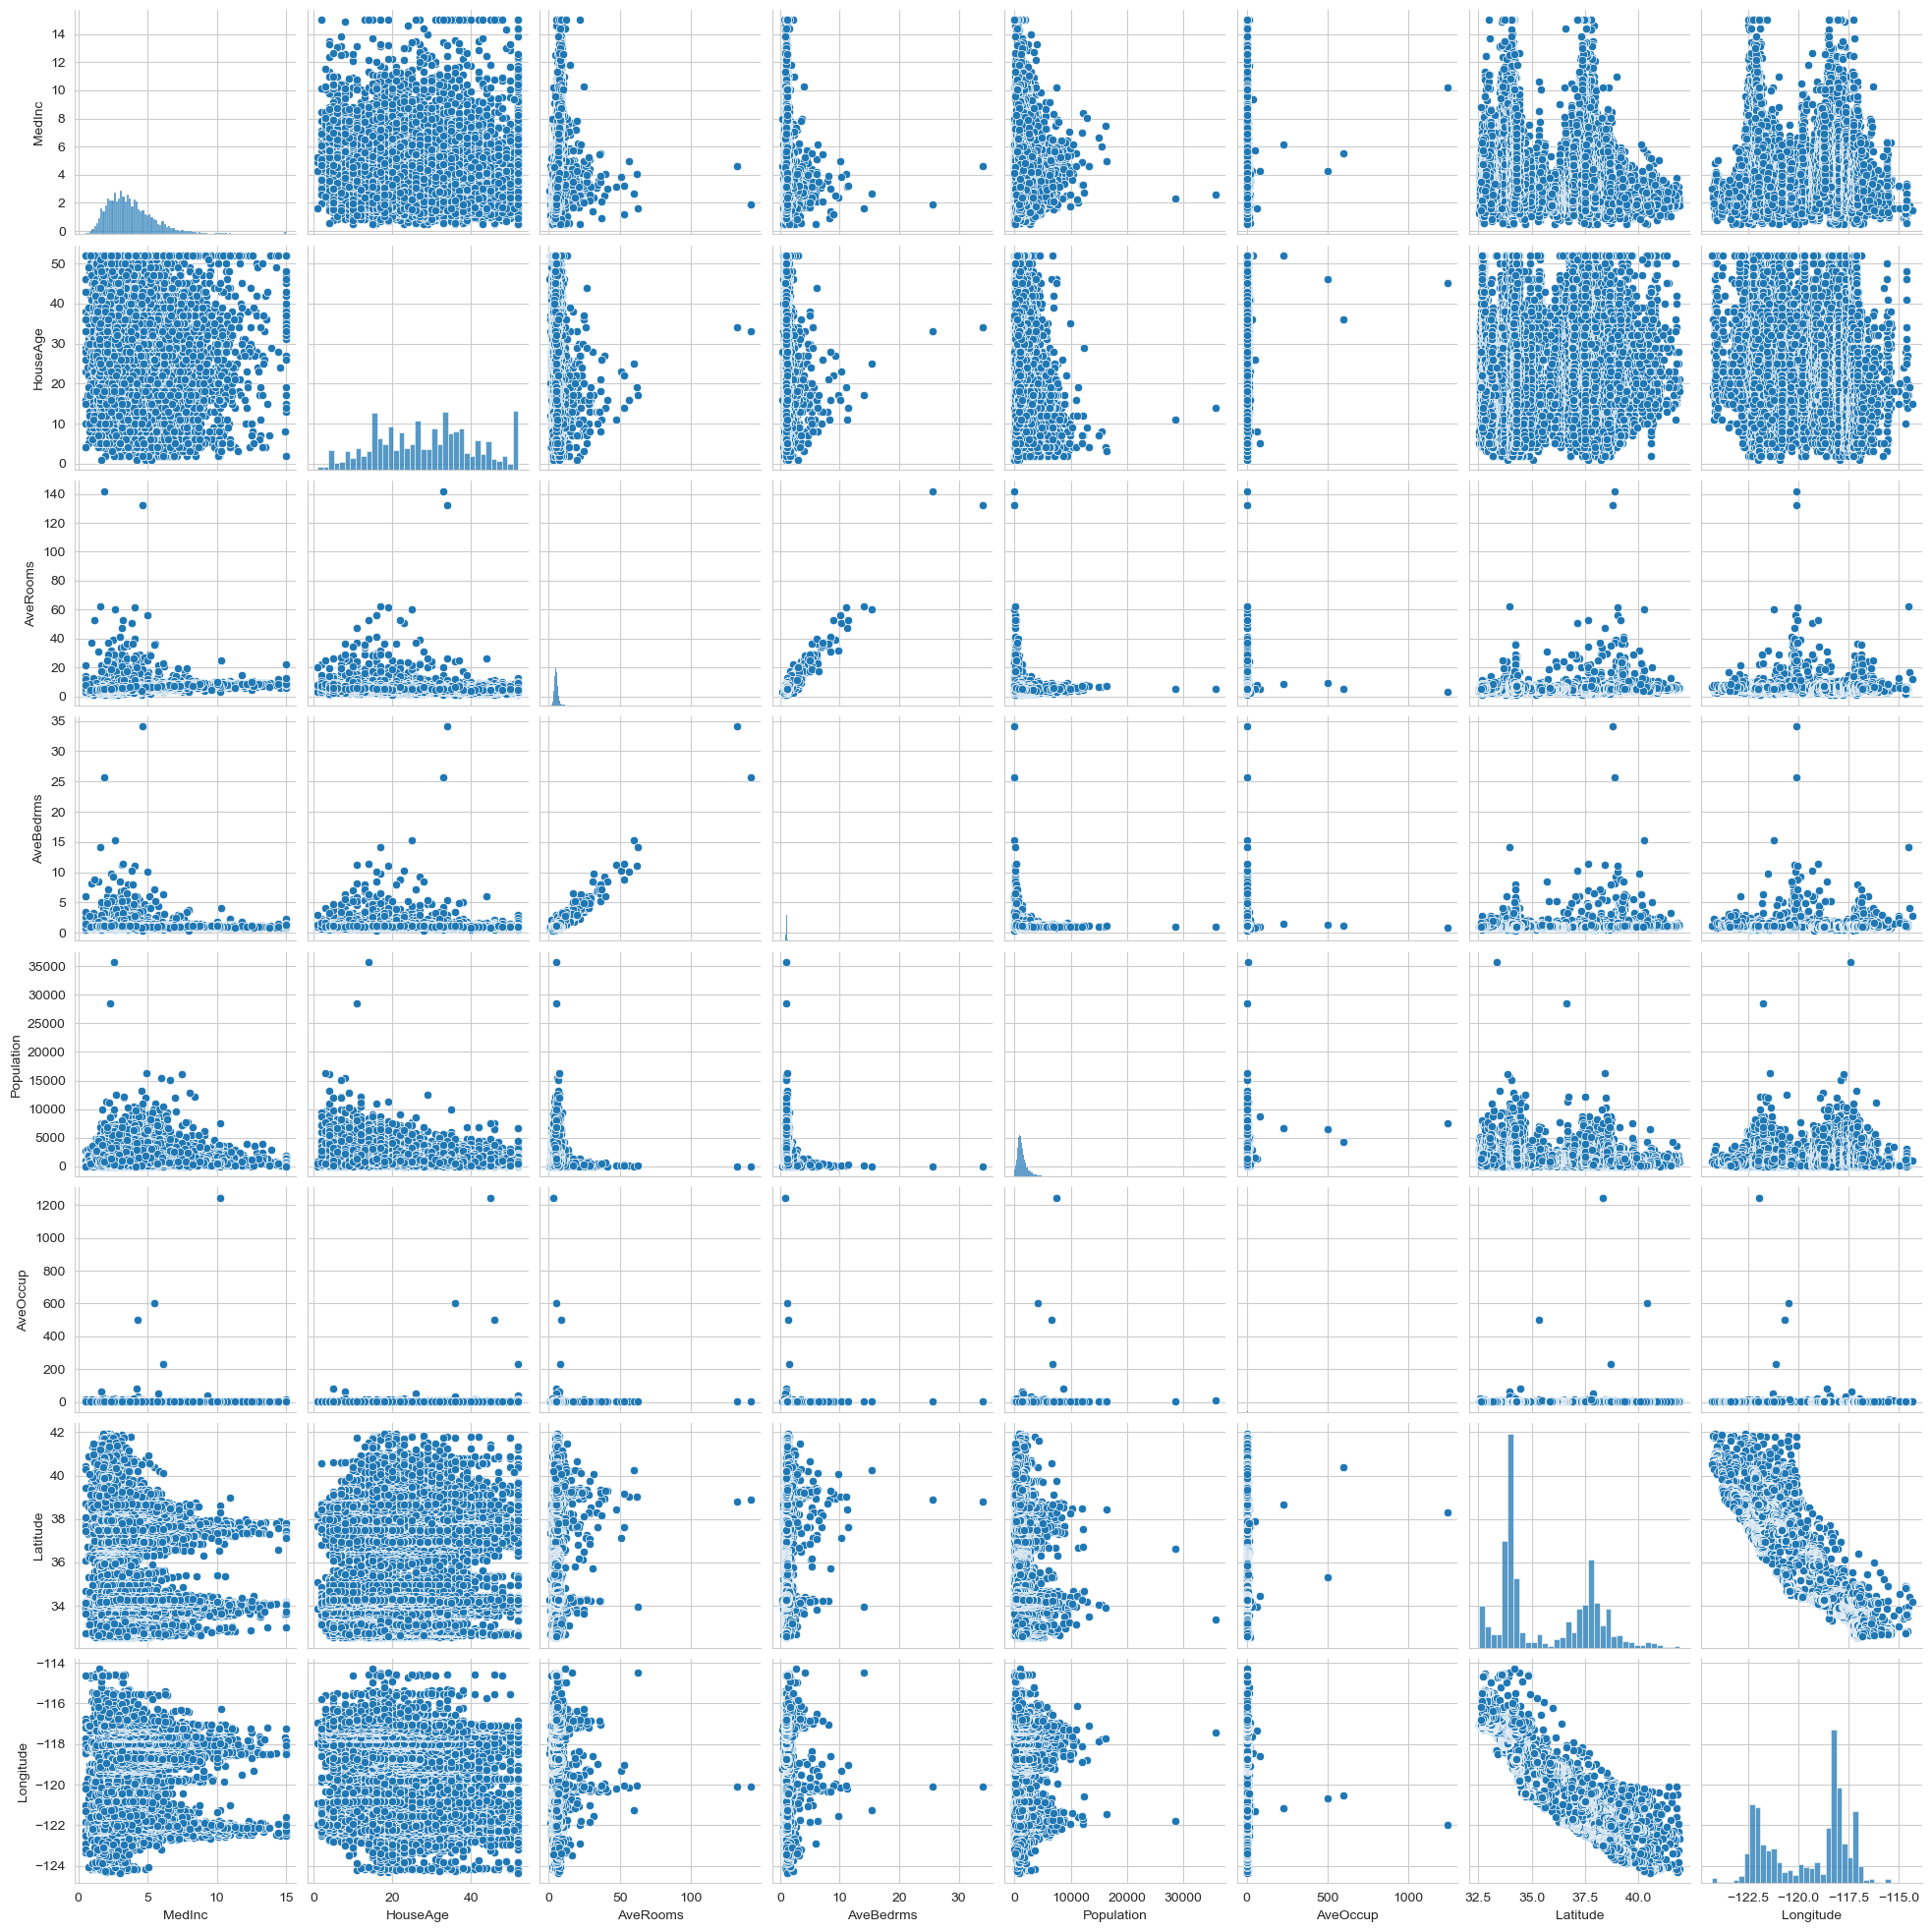

In [64]:
sns.pairplot(df);

Можно отметить несколько вещей:
* обратная корреляция между longitude и latitude --> оставляем только latitude
* прямая корреляция между avgrooms и avgbedrooms --> оставляем только avgrooms
* есть проблема с выбросами в параметре aveoccup: медиана этого параметра около нуля, но есть 4 выброса со значениями больше 100 - будем считать эти наблюдения не репрезентативными и удалим их

In [72]:
df_ed = df[['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude']]
df_ed.drop(df_ed[df_ed['AveOccup'] > 100].index, inplace = True)

In [83]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [85]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5
count,2.063600e+04,2.063600e+04,2.063600e+04,2.063600e+04,2.063600e+04,2.063600e+04
mean,7.913486e-17,-1.245477e-16,4.589879e-16,7.973877e-17,-1.214407e-16,-4.525068e-15
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-1.774432e+00,-2.196112e+00,-1.852257e+00,-1.257505e+00,-1.844800e+00,-1.447500e+00
25%,-6.884774e-01,-8.452143e-01,-3.993757e-01,-5.639767e-01,-4.230420e-01,-7.966469e-01
50%,-1.766687e-01,2.889621e-02,-8.070827e-02,-2.287123e-01,-1.051644e-01,-6.421279e-01
75%,4.593409e-01,6.646129e-01,2.519656e-01,2.648959e-01,2.745612e-01,9.732982e-01
max,5.859894e+00,1.856582e+00,5.516378e+01,3.030423e+01,6.565693e+01,2.958633e+00


In [87]:
X.shape

(20636, 6)

In [73]:
y = y[df_ed[df_ed['AveOccup'] <= 100].index]

In [75]:
y.shape

(20636,)

In [88]:
# разделим на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.2)

In [89]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

Как-то не очень получилось:

In [93]:
for i, k in zip([y_pred_train, y_pred_test], [y_train, y_test]):
    print(r2_score(k, i))

0.5439541763007743
0.5409326535894948


In [94]:
for i, k in zip([y_pred_train, y_pred_test], [y_train, y_test]):
    print(mean_squared_error(k, i))

0.6061084671387725
0.6157390134537102


Нарисуем график предсказанных значений против настоящих значений:

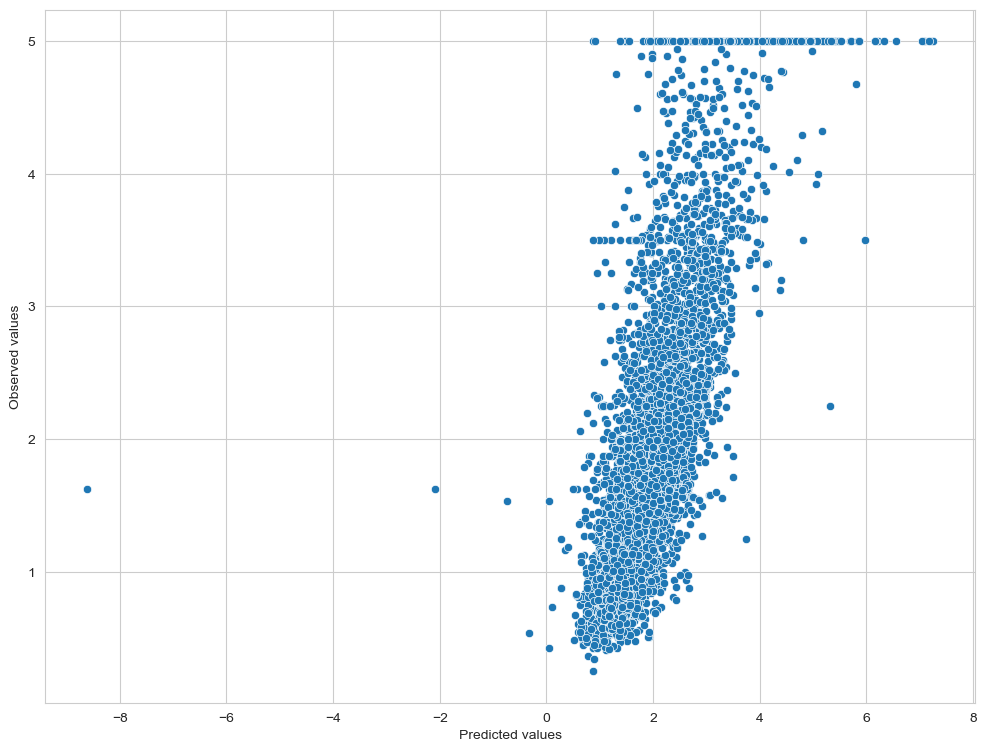

In [107]:
sns.scatterplot(x=y_pred_test, y=y_test);
plt.xlabel('Predicted values');
plt.ylabel('Observed values');

Можно видеть, что модель в целом хорошо воссоздала общий тренд, однако есть проблемы в районе больших значений (большой разюрос предсказаний модели для реальных значений около 5).

Посмотрим на коэффициенты модели:

In [96]:
for name, c in zip(df_ed.columns, linreg.coef_):
    print(f'coefficient for {name} is {c}')

coefficient for MedInc is 0.8195106049128585
coefficient for HouseAge is 0.22435745328541543
coefficient for AveRooms is -0.040797131557834196
coefficient for Population is 0.04487199060612313
coefficient for AveOccup is -0.18851567748302772
coefficient for Latitude is -0.10864912086895988


Как можно заметить, наибольший коэффициент, и соответственно, параметр, вносящий наибольший вклад в финальное предсказание - MedInc. В то же время, наименее важными параметрами являются AveRooms и Population.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задачах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [110]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1/(1 + np.exp**(-output)) 

In [111]:
sigmoid(20), sigmoid(-50)

(0.9999999979388463, 1.928749847963923e-22)

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [112]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -(np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))/n)
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return X.T @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [113]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(X_test @ self.W)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [114]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

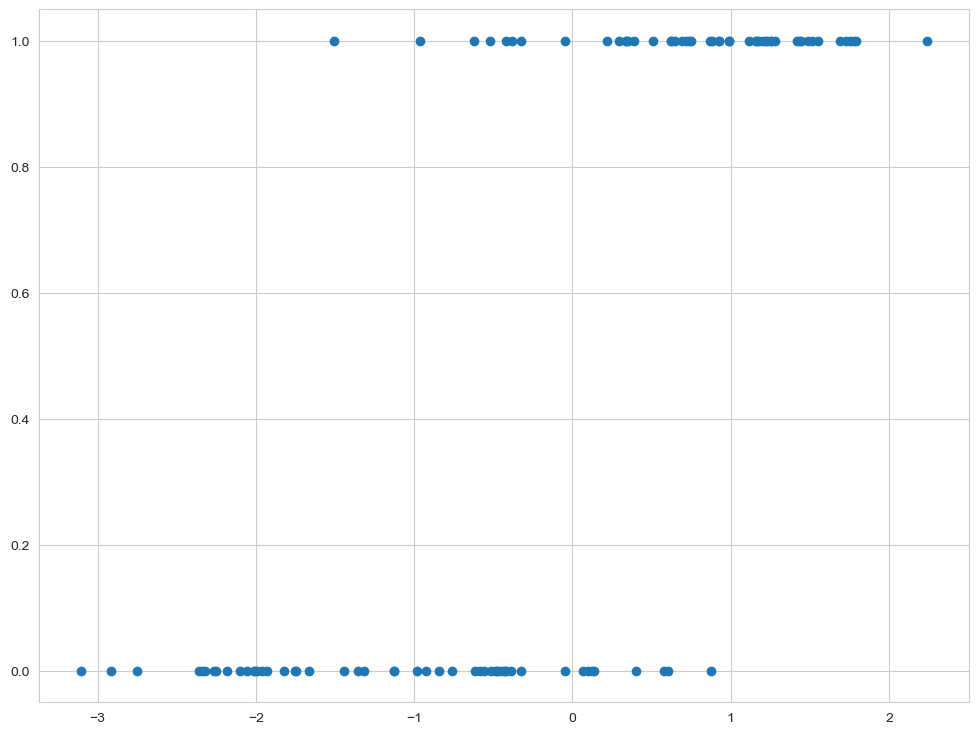

In [115]:
plt.scatter(X, y);

In [116]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

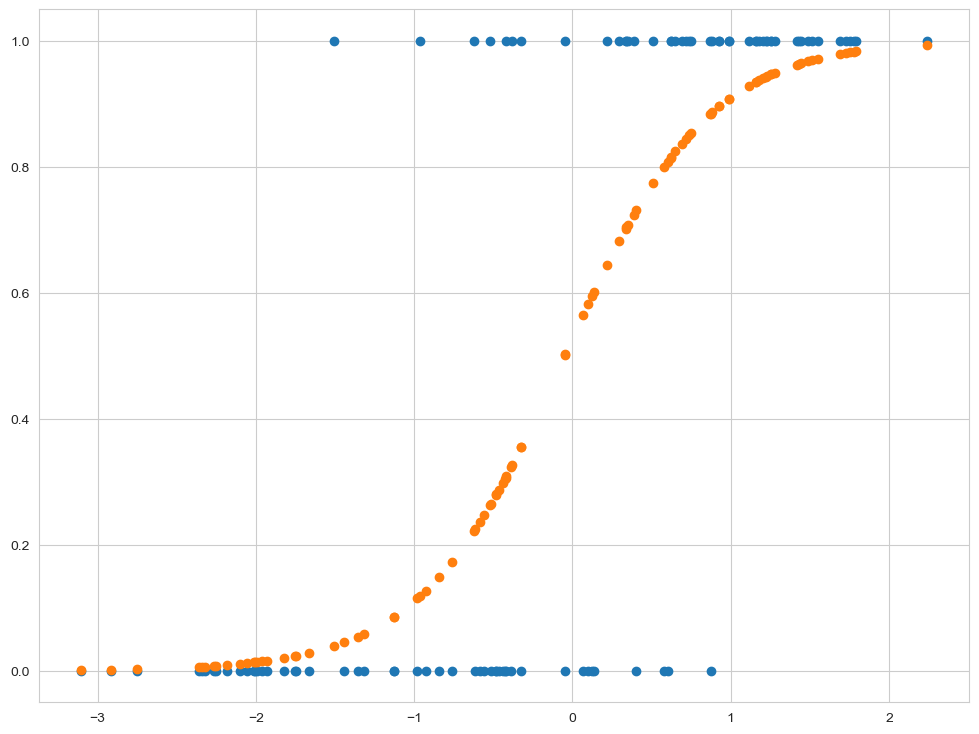

In [117]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Чтобы перевести эти вероятности в значения, запишем в новую переменную как 0 все значения с p<0.5, а остальные - как 1 (по идее, это можно было сделать сразу в классе, но вероятности сами по себе бывают достаточно полезными и более гибкими для интерпретации, поэтому оставим в классе их):

In [124]:
y_pred_01 = [1 if i >= 0.5 else 0 for i in y_pred]
np.unique(y), np.unique(y_pred_01)

(array([0, 1]), array([0, 1]))

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

Для бинарной классификации используются следующие метрики, которые могут быть нам полезны тут:
* precision
* recall
* f1-score
* accuracy

Посмотрим на их значения на наших результатах:

In [187]:
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,
                             accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, ConfusionMatrixDisplay, 
                            roc_auc_score, RocCurveDisplay)

In [129]:
for metr in [r2_score, mean_absolute_error, mean_squared_error,
             accuracy_score, f1_score, precision_score, recall_score]:
    print(metr.__name__, metr(y, y_pred_01))

r2_score 0.36
mean_absolute_error 0.16
mean_squared_error 0.16
accuracy_score 0.84
f1_score 0.8431372549019608
precision_score 0.8269230769230769
recall_score 0.86


В целом, значения очень хорошие

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [130]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [133]:
pokemon.shape

(800, 13)

In [147]:
# пофиксим индексацию (удалим ненужный столбец)
pokemon.drop(columns=['#'], inplace=True)

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

### Проверяем на NA:

In [132]:
for column in pokemon.columns:
    print(column+", number of NA =", pokemon.isna()[column].sum())

#, number of NA = 0
Name, number of NA = 0
Type 1, number of NA = 0
Type 2, number of NA = 386
Total, number of NA = 0
HP, number of NA = 0
Attack, number of NA = 0
Defense, number of NA = 0
Sp. Atk, number of NA = 0
Sp. Def, number of NA = 0
Speed, number of NA = 0
Generation, number of NA = 0
Legendary, number of NA = 0


Видно, что пропуски есть только в столбце Type 2, причем их достаточно много - 386 из 800 значений. Если бы их было не так много, мы бы могли бы их заполнить предсказанными простой моделью значениями или просто средним/медианой. Но в нашем случае лучше просто не рассматривать эту переменную.

In [135]:
pokemon = pokemon.drop(columns=['Type 2'])

### Посмотрим на типы значений в колонках:

In [136]:
pokemon.dtypes

#              int64
Name          object
Type 1        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

Можем видеть, что все переменные у нас численные, кроме Name и Type 1. Name кажется аналогом id, поэтому посмотрим, есть ли в этом столбце вообще повторяющиеся значения:

In [139]:
len(pokemon['Name'].unique())

800

Действительно, имена покемонов уникальны, поэтому нет смысла использовать эту колонку для тренировки модели и предсказаний. Посмотрим на значения Type 1:

In [141]:
pokemon.drop(columns=['Name'], inplace=True)

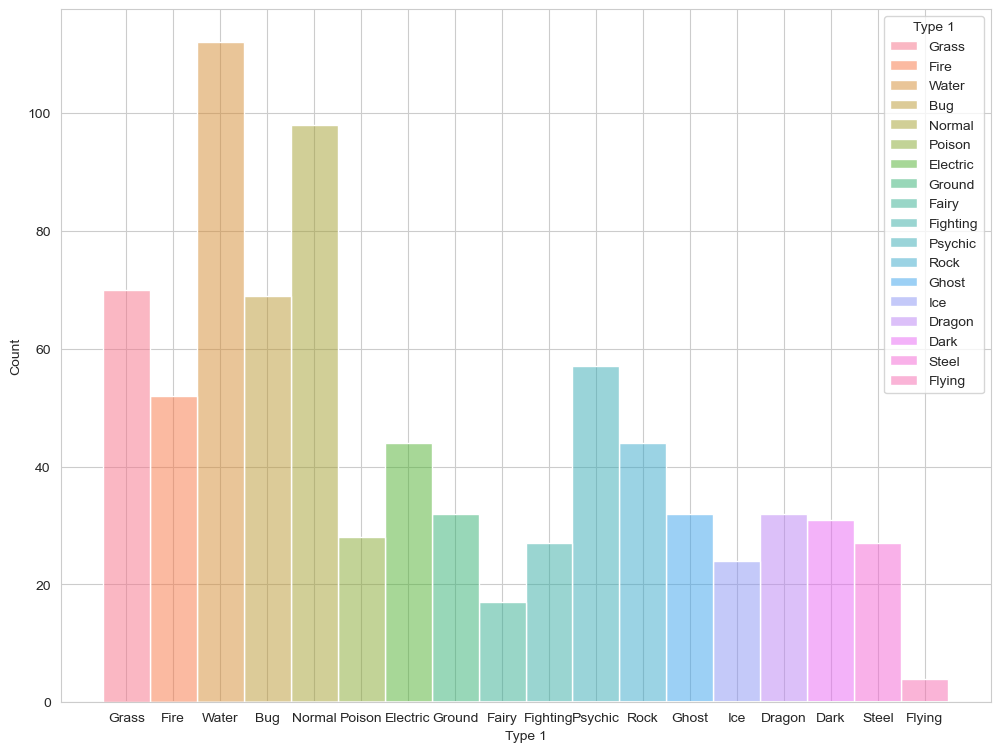

In [145]:
sns.histplot(data=pokemon, x='Type 1', hue='Type 1');

Всего существует 18 разных типов, самыми популярными из которых являются Water и Normal.

Теперь мы можем разделить признаки на численные/категориальные и закодировать категориальный признак:

In [153]:
X = pokemon[['Type 1', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def',
       'Speed', 'Generation']]
y = pokemon['Legendary']

category = ['Type 1'] # --> OHE
quantative = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation'] # --> StandartScaler

### Посмотрим на корреляции и распределение признаков:

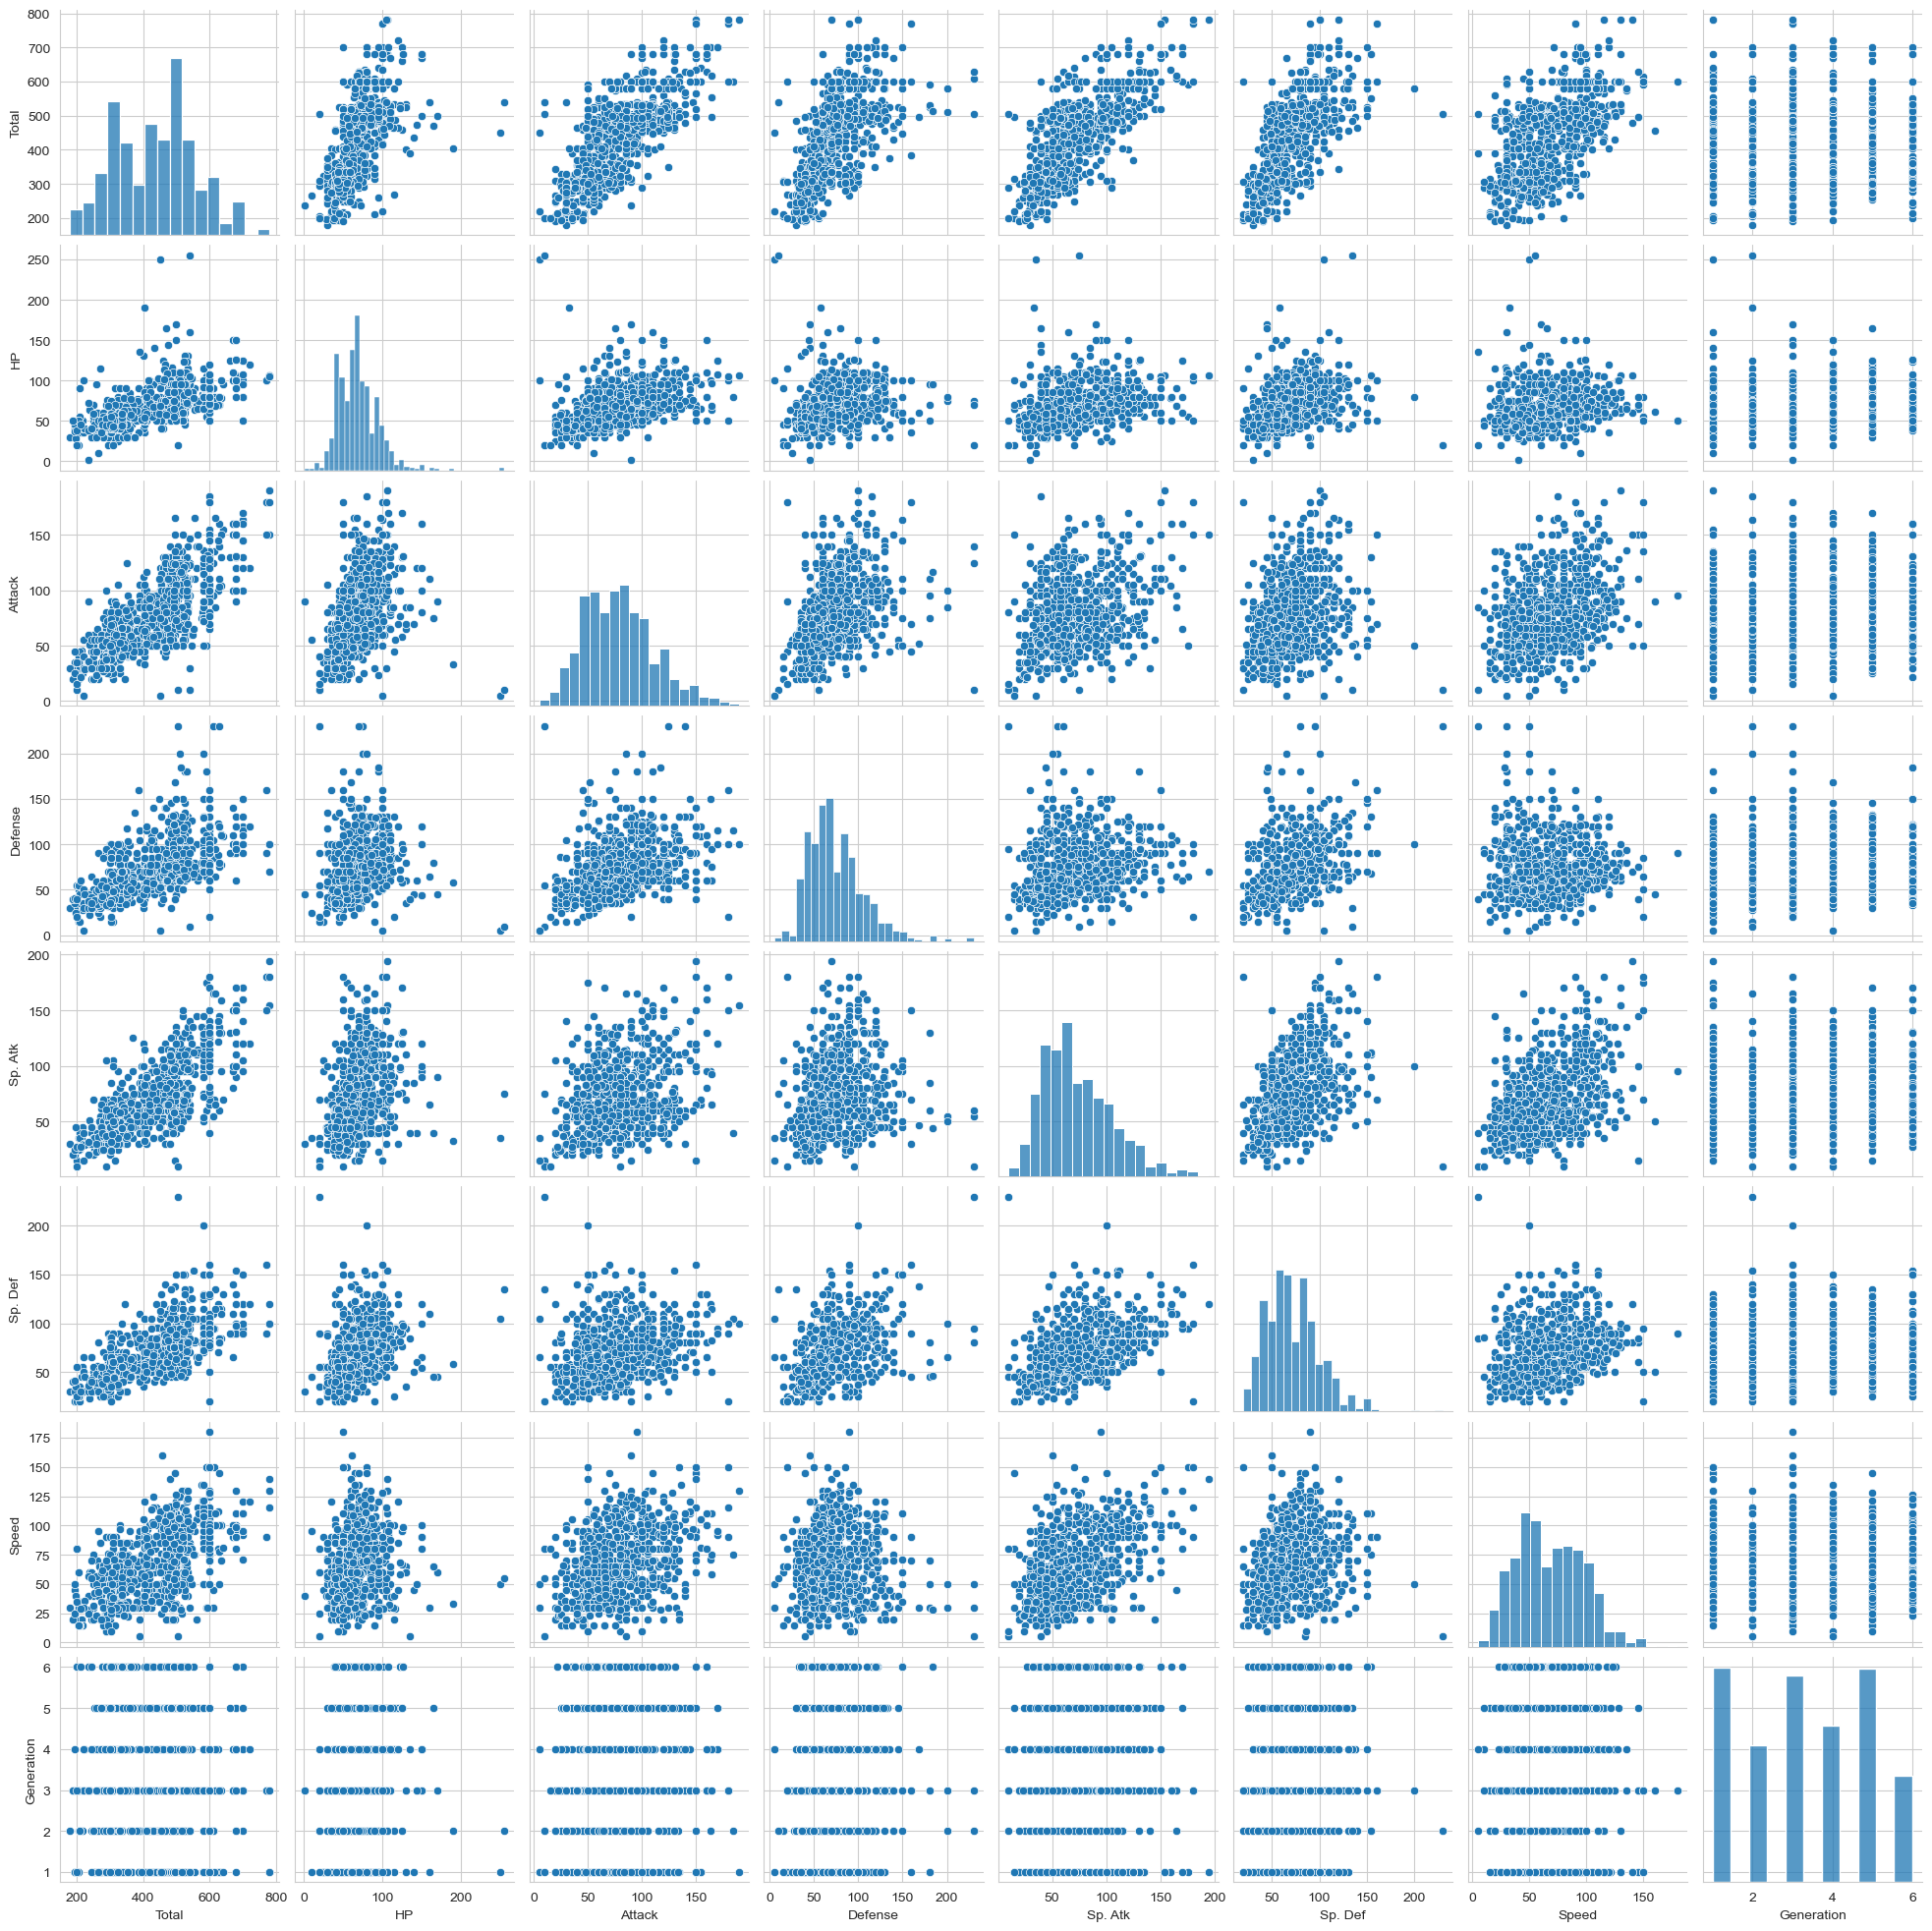

In [155]:
sns.pairplot(X);

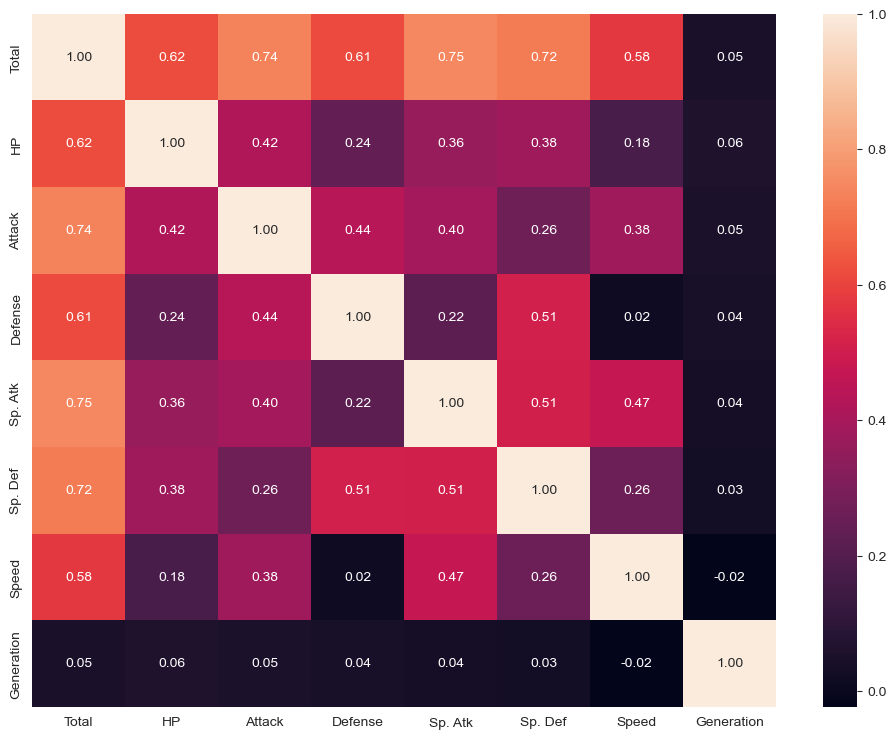

In [156]:
sns.heatmap(X.corr(), annot=True, fmt='.2f');

Мы можем видеть, что переменная Total сильно скореллирована со всеми параметрами, кроме Genaration. Кажется, что она сама по себе может быть хорошим предиктором. Из этой ситуации есть два выхода: либо удалить этот столбец совсем, либо применить регуляризацию весов модели. Здесь мы проверим оба варианта, для этого сделаем два датасета.

In [160]:
X_with_total = X.copy()
X_without_total = X.drop(columns=['Total'])

In [161]:
X.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Можем видеть, что данные требуют нормализации.

В целом, надо сказать, что в этом датасете явный дисбаланс классов, так как есть только несколько легендарных покемонов среди подавляющего большинства обычных. В таких случаях обычно пытаются догенерить недостающий класс, но тут мы представим, что такой проблемы нет и просто учтем это при подсчете метрик.


Разделите ваши данные на тестовую и тренировочную выборку.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_with_total, y, test_size=0.3, random_state=10)
X_train.head()

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
142,Water,535,130,85,80,85,95,60,1
399,Ice,410,90,60,70,75,70,45,3
571,Grass,498,75,98,63,98,63,101,5
386,Ghost,455,64,115,65,83,63,65,3
452,Grass,515,60,70,65,125,105,90,4


Обучите модель `LogisticRegression` из `sklearn`.

In [169]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), quantative),
    ("ohe", OneHotEncoder(drop="first"), category)
])

log_regr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logregr", LogisticRegression())
])

log_regr_pipeline.fit(X_train, y_train)
y_pred_with_total = log_regr_pipeline.predict(X_test)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_without_total, y, test_size=0.3, random_state=10)
X_train.head()

quantative = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), quantative),
    ("ohe", OneHotEncoder(drop="first"), category)
])

log_regr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logregr", LogisticRegression())  # turned out that l2 regularization is applied by default
])

log_regr_pipeline.fit(X_train, y_train)
y_pred_without_total = log_regr_pipeline.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [182]:
for metr in [r2_score, mean_absolute_error, mean_squared_error,
             accuracy_score, f1_score, precision_score, recall_score]:
    print(f'{metr.__name__} :  {metr(y_test.astype(int), y_pred_without_total.astype(int))} without total and {metr(y_test.astype(int), y_pred_with_total.astype(int))} with')

r2_score :  0.2909090909090907 without total and 0.2909090909090907 with
mean_absolute_error :  0.05416666666666667 without total and 0.05416666666666667 with
mean_squared_error :  0.05416666666666667 without total and 0.05416666666666667 with
accuracy_score :  0.9458333333333333 without total and 0.9458333333333333 with
f1_score :  0.5185185185185185 without total and 0.5185185185185185 with
precision_score :  1.0 without total and 1.0 with
recall_score :  0.35 without total and 0.35 with


Разницы без/с Total нет.
На confusion matrix можем видеть, что модель угадала большинство отрицательных ответов. При этом, учитывая, что у нас всего было мало легендарных покемонов, разница между 7 и 13 значительная - то есть модель ошибается примерно в половине положительных случаев. Метрики выше это особо не показывают, кроме recall, по которому можно заметить, что модель работает ралеко не идеально.

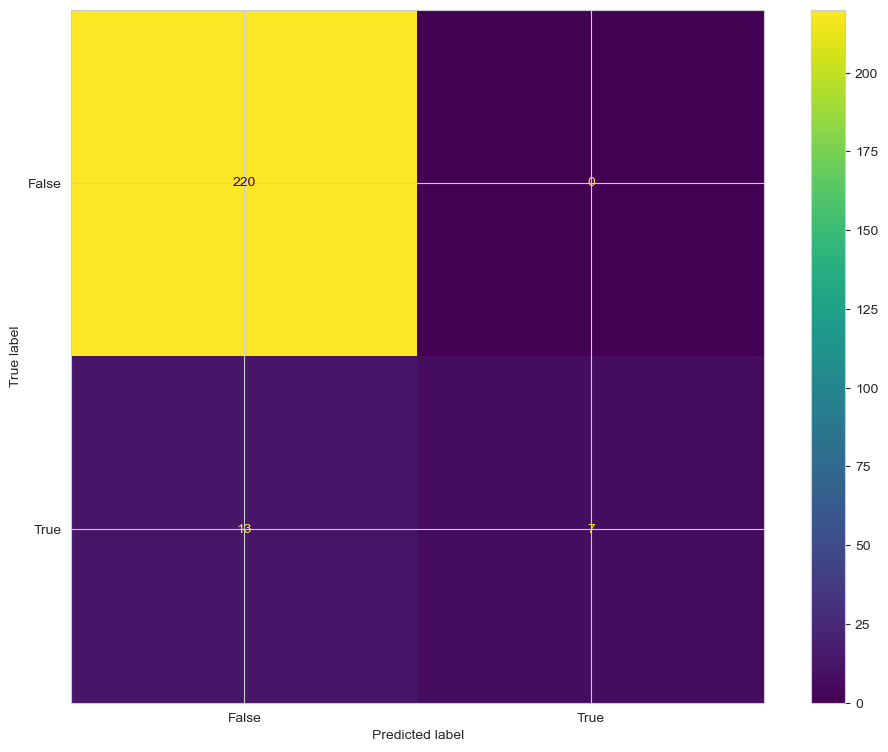

In [186]:
cm = confusion_matrix(y_test, y_pred_without_total, labels=log_regr_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_regr_pipeline.classes_)
disp.plot()
plt.show()

ROC кривая и значение метрики:

In [188]:
roc_auc_score(y_test, y_pred_without_total)

0.675

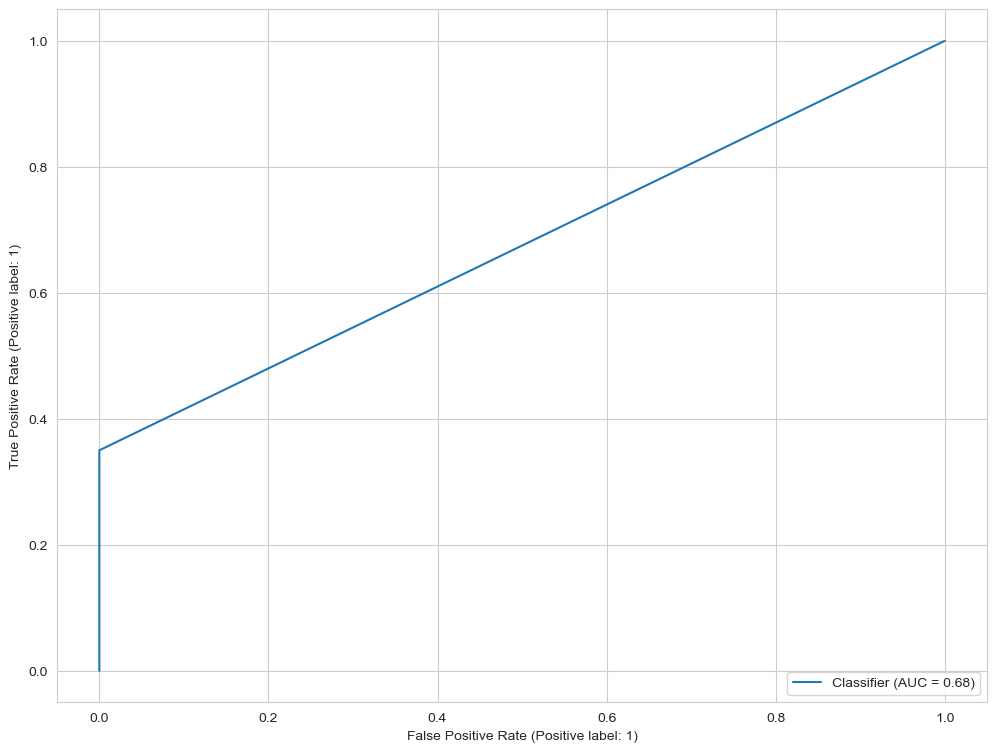

In [189]:
RocCurveDisplay.from_predictions(y_test, y_pred_without_total)
plt.show()

Кривая получилась достаточно прямая... и хотелось бы, чтобы значения TPR для небольших FPR были больше. Наша модель совсем неидеальна, но при этом уловила основной тренд. 

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Очень люблю Nothing but Thieves - это что-то такое, что все мы когда-то слушали в 16 лет, из разряда мелодичный роцк) Мне особенно нравится голос вокалиста и как он нереально передает эмоции. Советую послушать разное из Broken Machine и Is Everybody Going Crazy? из Moral Panic

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**